In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 
     |████████████████████████████████| 9.9 MB 44.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import math

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm

import pmdarima.arima as pmd
from pmdarima import model_selection
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [3]:
!cp "/content/drive/MyDrive/KLEEMANN/2_year_samples.xlsx" "/content"

In [4]:
# Define xlsx filename
filename = "/content/2_year_samples.xlsx"
# Read the .xlsx
df = pd.read_excel(filename)
# Drop columns that we don't need
df_cleaned = df.drop(df.columns[[0, 7]],axis = 1)
# Set Dataframe's dtype to float32
df_cleaned = df_cleaned.astype(np.float32)
print(df_cleaned.shape)
df_cleaned.head()

(109970, 6)


,SPEED UP,NOISE UP,PRESSURE UP,SPEED DOWN,NOISE DOWN,PRESSURE DOWN
0,0.0,51.049999,15.66,0.00,56.360001,17.17
1,0.0,51.049999,15.66,0.00,56.099998,16.68
2,0.0,51.189999,15.66,0.00,55.939999,16.68
3,0.0,52.139999,15.66,0.00,55.939999,15.29
4,0.0,52.139999,15.66,0.07,55.869999,15.29


In [5]:
feature_types = ['SPEED UP', 'NOISE UP', 'PRESSURE UP', 'SPEED DOWN', 'NOISE DOWN', 'PRESSURE DOWN']
orders = {'SPEED UP': (6,0,5),
          'NOISE UP': (15,0,0),
          'PRESSURE UP': (0,1,0),
          'SPEED DOWN': (8,0,3),
          'NOISE DOWN': (0,1,0),
          'PRESSURE DOWN': (1,1,0)}

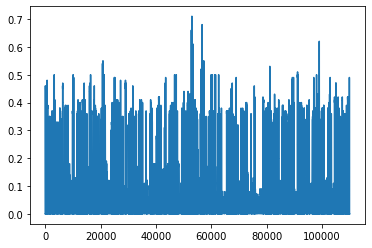

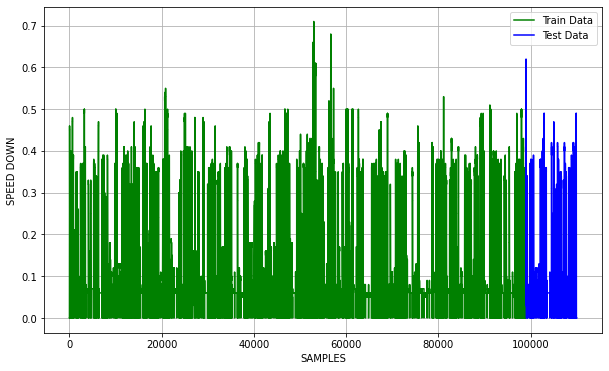

100%|██████████| 10997/10997 [51:10<00:00,  3.58it/s]


In [33]:
for feature in ['SPEED DOWN']:
    with open(f"tsa_logs.txt",'w',encoding = 'utf-8') as f:
        
        data = df_cleaned[feature]
        plt.plot(df_cleaned.index, data)
        plt.show()

        # Train test split
        to_row = int(len(df_cleaned)*0.9)
        training_data = list(df_cleaned[0:to_row][feature])
        testing_data = list(df_cleaned[to_row:][feature])

        plt.figure(figsize=(10, 6))
        plt.grid(True)
        plt.xlabel('SAMPLES')
        plt.ylabel(feature)
        plt.plot(df_cleaned[0:to_row][feature], 'green', label='Train Data')
        plt.plot(df_cleaned[to_row:][feature], 'blue', label='Test Data')
        plt.legend()
        plt.show()

        to_test_data = []
        predictions = []
        seq_len = 15
        len_testing = len(testing_data)

        for i in range(len(training_data)-seq_len, len(df_cleaned)-seq_len):
            to_test_data.append(list(df_cleaned[feature].iloc[i:i+seq_len]))

        for i in tqdm(range(len_testing), total=len(range(len_testing))):
            model = ARIMA(to_test_data[i], order=orders[feature], enforce_stationarity=False)
            model_fit = model.fit()
            output = model_fit.forecast()
            y_hat = list(output)[0]
            predictions.append(y_hat)

        sample_range = df_cleaned[to_row:].index

        # plt.figure(figsize=(15,9))
        # plt.grid(True)
        # plt.plot(sample_range, predictions, color='blue', marker='o', linestyle='dashed', label=f'PREDICTED {feature}')
        # plt.plot(sample_range, testing_data, color='red', label=f'ACTUAL {feature}')
        # plt.title(f'{feature} PREDICTION')
        # plt.xlabel('SAMPLES')
        # plt.ylabel(f'{feature}')
        # plt.legend()
        # plt.savefig(f"tsa_{feature}_predictions.jpg")
        # plt.show()

        # # report performance
        # MSE = mean_squared_error(testing_data, predictions)
        # print(f"\nMean Squared Error: {MSE}\n")
        # f.write(f"MSE for {feature}: {MSE}\n")

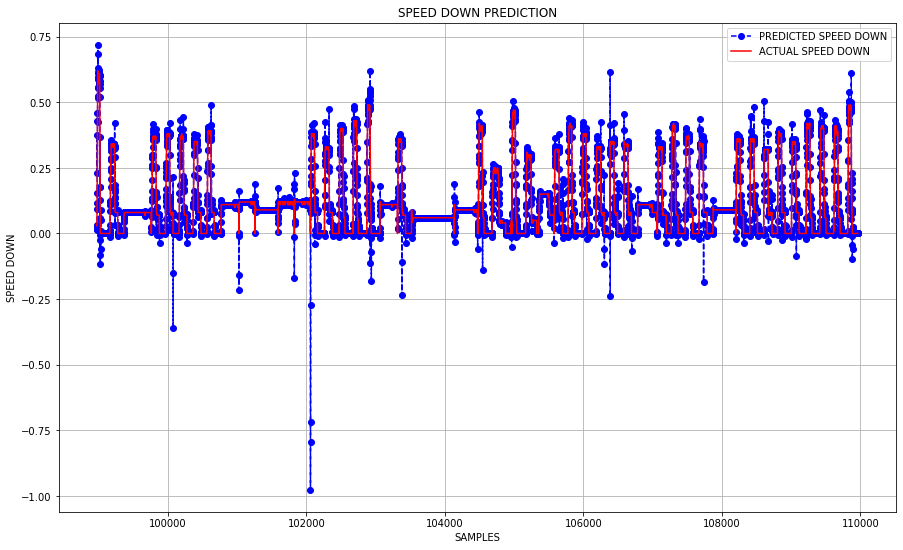

In [51]:
plt.figure(figsize=(15,9))
plt.grid(True)
plt.plot(sample_range[:-6], predictions, color='blue', marker='o', linestyle='dashed', label=f'PREDICTED {feature}')
plt.plot(sample_range[:-6], testing_data, color='red', label=f'ACTUAL {feature}')
plt.title(f'{feature} PREDICTION')
plt.xlabel('SAMPLES')
plt.ylabel(f'{feature}')
plt.legend()
plt.savefig(f"tsa_{feature}_predictions.jpg")
plt.show()

In [47]:
min(predictions)

-0.9757386780804131

In [46]:
predictions.pop(np.argmin(predictions))
testing_data.pop(np.argmin(predictions))

0.05999999865889549

In [48]:
print(len(testing_data))
print(len(predictions))

10991
10991


In [49]:
with open(f"tsa_logs.txt",'w',encoding = 'utf-8') as f:
    MSE = mean_squared_error(testing_data, predictions)
    print(f"\nMean Squared Error: {MSE}\n")
    f.write(f"MSE for {feature}: {MSE}\n")


Mean Squared Error: 0.0009505857370962825

